# Thyroid Cancer Prediction: Comparative Analysis for Clinical Decision Support

This notebook presents an end-to-end machine learning system for predicting thyroid cancer diagnosis (Benign vs Malignant). 

### System Features:
- **Feature Engineering**: Comprehensive use of clinical, demographic, and laboratory data.
- **Data Integrity**: strict separation of training and testing data to ensure unbiased evaluation.
- **Model Comparison**: comparative analysis of Decision Tree and Random Forest classifiers.
- **Clinical Prediction Interface**: Modular system for real-world patient risk assessment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

## 1. Data Preparation

In [2]:

df = pd.read_csv('data/thyroid_cancer_risk_data.csv')

df['Diagnosis'] = df['Diagnosis'].map({'Benign': 0, 'Malignant': 1})

# Feature and Target Selection
X = df.drop(columns=['Patient_ID', 'Diagnosis'])
y = df['Diagnosis']

# Split before preprocessing to prevent leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training instances: {X_train.shape[0]}")
print(f"Testing instances: {X_test.shape[0]}")

Training instances: 170152
Testing instances: 42539


## 2. Pipeline Architecture


In [3]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

## 3. Model Training & Comparative Evaluation

In [4]:
results = {}
pipelines = {}

def evaluate_model(clf, name):
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    # Store metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'CM': confusion_matrix(y_test, y_pred)
    }
    pipelines[name] = pipe
    
    print(f"{name} Evaluation Complete.")

# Train Models
evaluate_model(DecisionTreeClassifier(max_depth=5, random_state=42), "Decision Tree")
evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), "Random Forest")

Decision Tree Evaluation Complete.
Random Forest Evaluation Complete.


### 3.1 Visual Performance Comparison

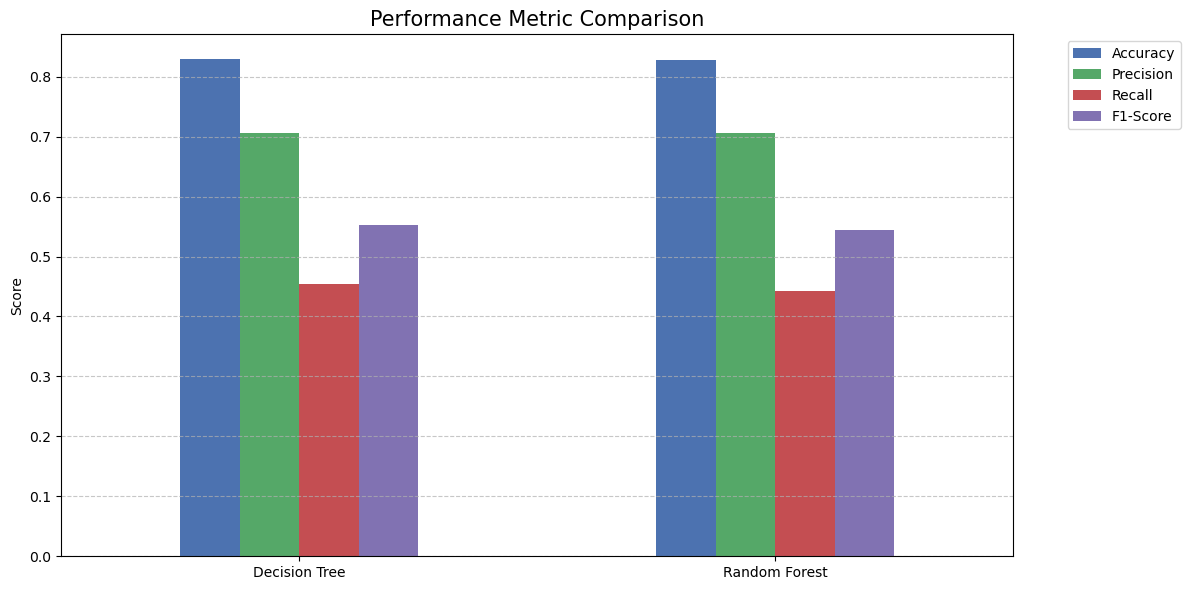

In [5]:
# Metric Comparison Plot
df_metrics = pd.DataFrame(results).T.drop(columns=['CM'])
df_metrics.plot(kind='bar', figsize=(12, 6), rot=0, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2'])
plt.title('Performance Metric Comparison', fontsize=15)
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

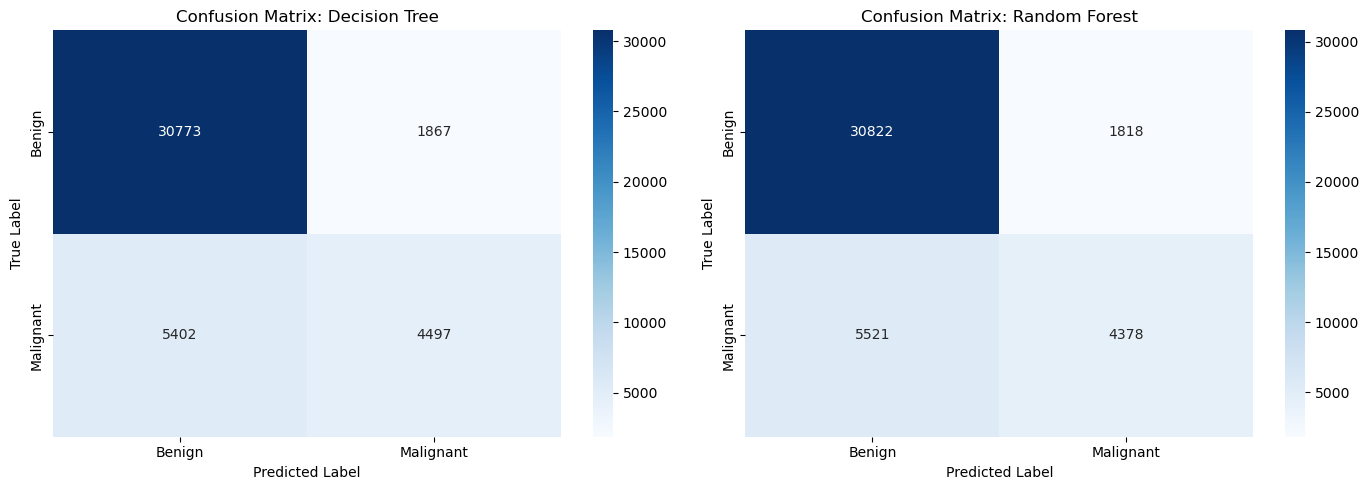

In [6]:
# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, (name, res) in enumerate(results.items()):
    sns.heatmap(res['CM'], annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    axes[i].set_title(f'Confusion Matrix: {name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

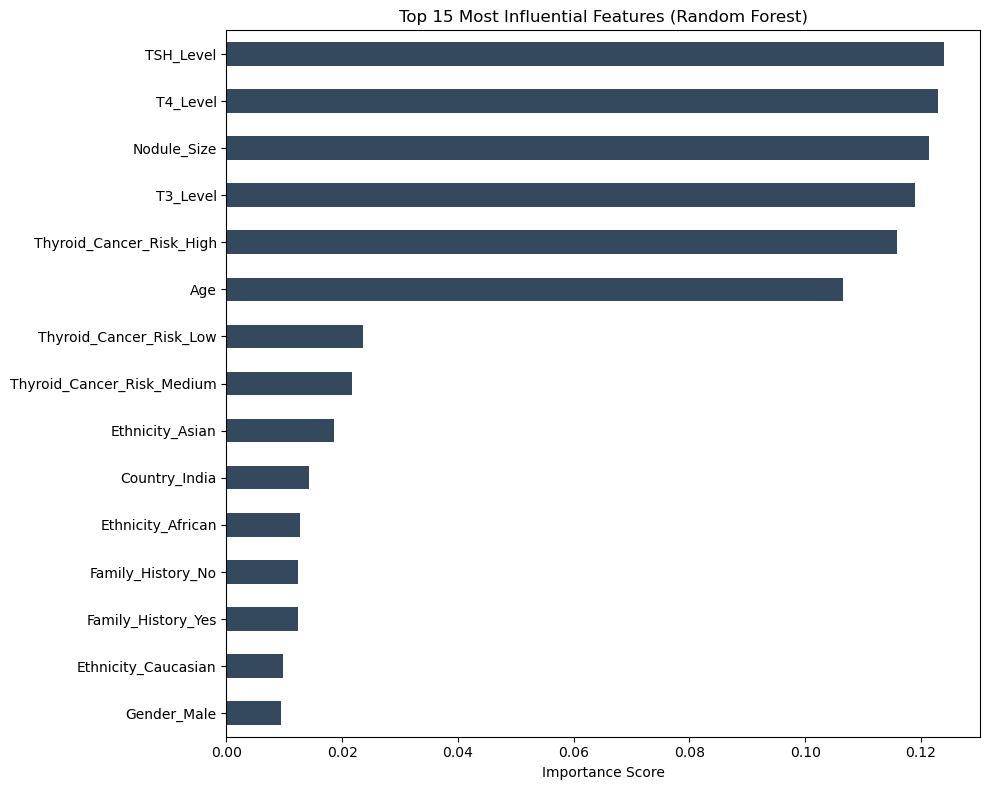

In [7]:
# Random Forest Feature Importance
rf_pipe = pipelines["Random Forest"]
importances = rf_pipe.named_steps['classifier'].feature_importances_

# Get feature names after one-hot encoding
onehot_cols = rf_pipe.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(onehot_cols)

feat_importances = pd.Series(importances, index=all_feature_names).sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 8))
feat_importances.plot(kind='barh', color='#34495e')
plt.title('Top 15 Most Influential Features (Random Forest)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. Part 4: Clinical Prediction Interface
A standardized interface for new patient assessments using the choice of two trained models.

In [8]:
def predict_new_patient(patient_data, model_choice='Random Forest'):
    """
    Parameters:
        patient_data (dict): patient observations.
        model_choice (str): 'Decision Tree' or 'Random Forest'.
    """
    pipeline = pipelines.get(model_choice)
    if not pipeline:
        return "Invalid Model Choice", 0
    
    patient_df = pd.DataFrame([patient_data])
    patient_df = patient_df[X.columns]  # Ensure column order
    
    pred_class = pipeline.predict(patient_df)[0]
    pred_prob = pipeline.predict_proba(patient_df)[0][pred_class]
    
    result = "Malignant" if pred_class == 1 else "Benign"
    return result, pred_prob

## 5. Part 5: Demonstration & Testing

In [9]:
def run_academic_test():
    # Standard Test Patient Case
    sample_patient = {
        'Age': 45, 'Gender': 'Female', 'Country': 'Canada', 'Ethnicity': 'Caucasian',
        'Family_History': 'No', 'Radiation_Exposure': 'No', 'Iodine_Deficiency': 'No',
        'Smoking': 'No', 'Obesity': 'No', 'Diabetes': 'No', 'TSH_Level': 1.8,
        'T3_Level': 2.1, 'T4_Level': 11.5, 'Nodule_Size': 3.2, 'Thyroid_Cancer_Risk': 'High'
    }
    
    print("--- Academic Test Suite: Clinical Prediction ---")
    
    for model_name in ["Decision Tree", "Random Forest"]:
        diagnosis, confidence = predict_new_patient(sample_patient, model_choice=model_name)
        print(f"\nModel: {model_name}")
        print(f"Predicted Diagnosis: {diagnosis}")
        print(f"Confidence Level:    {confidence:.2%}")

run_academic_test()

--- Academic Test Suite: Clinical Prediction ---

Model: Decision Tree
Predicted Diagnosis: Malignant
Confidence Level:    70.20%

Model: Random Forest
Predicted Diagnosis: Malignant
Confidence Level:    55.00%
